In [22]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model, load_model
from keras import applications
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
import tensorflow as tf


# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# Set the random seed in tensorflow at graph level
tf.compat.v1.set_random_seed(111)
# Define a tensorflow session with above session configs
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# Set the session in keras
tf.compat.v1.keras.backend.set_session(sess)

### Creating an empty model

In [2]:
def create_empty_model():
    model = applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False, #Default:(299,299,3)
        weights='imagenet',
        input_shape=(299,299,3),
        pooling='max'
    )

    # Freeze layers
    for layer in model.layers:
        layer.trainable = False

    # Add trainable layers to the model
    x = model.output
    #model.summary()
    predictions = Dense(2, activation='softmax')(x)

    # Create the final model and compile it
    final_model = Model(inputs=model.input, outputs=predictions)

    # Compile model with optimization setting
    opt = Adam(lr=0.001, decay=1e-5)
    final_model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

    return final_model

### Loading in the best models for normal vs pneumonia and bacterial vs viral

In [3]:
normpneum_test_model = create_empty_model()
normpneum_test_model.load_weights('best_normpneum_checkpoint.hdf5')
bactviral_test_model = create_empty_model()
bactviral_test_model.load_weights('best_bactviral_checkpoint.hdf5')

















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Loading in images

In [4]:
bacteria_path = Path("chest_xray/images/train/BACTERIA")
virus_path = Path("chest_xray/images/train/VIRUS")
normal_path = Path("chest_xray/images/train/NORMAL")

In [5]:
bacteria_filenames = []
virus_filenames = []
normal_filenames = []

for (dirpath, dirnames, filenames) in os.walk(bacteria_path):
    bacteria_filenames += [os.path.join(dirpath, file) for file in filenames]
for (dirpath, dirnames, filenames) in os.walk(virus_path):
    virus_filenames += [os.path.join(dirpath, file) for file in filenames]
for (dirpath, dirnames, filenames) in os.walk(normal_path):
    normal_filenames += [os.path.join(dirpath, file) for file in filenames]

### Select some images to show

Text(0.5, 1.0, 'Virus')

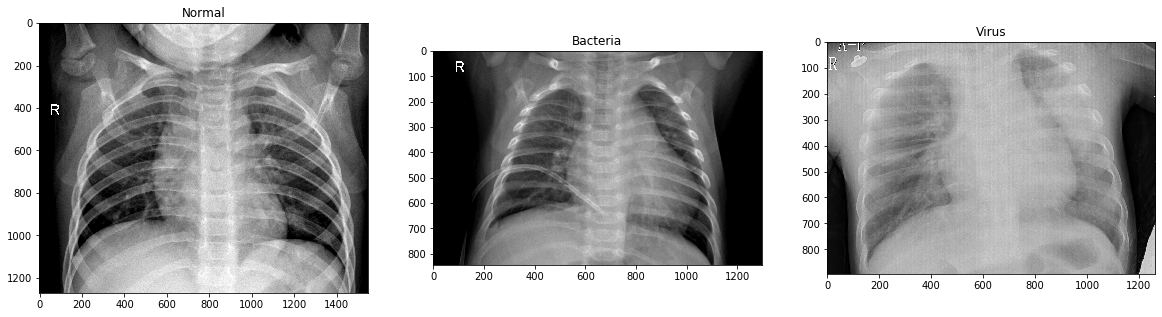

In [6]:
import random
normal_index = random.randrange(len(normal_filenames))
norm_img_filename = normal_filenames[normal_index]
norm_image = np.array(load_img(norm_img_filename), dtype=np.uint8)

bacteria_index = random.randrange(len(bacteria_filenames))
bac_img_filename = bacteria_filenames[bacteria_index]
bac_image = np.array(load_img(bac_img_filename), dtype=np.uint8)


virus_index = random.randrange(len(virus_filenames))
vir_img_filename = virus_filenames[virus_index]
virus_image = np.array(load_img(vir_img_filename), dtype=np.uint8)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
ax1.imshow(norm_image)
ax1.set_title('Normal')
ax2.imshow(bac_image)
ax2.set_title('Bacteria')
ax3.imshow(virus_image)
ax3.set_title('Virus')

### Final layer of the models

In [7]:
normpneum_final_layer = 'block8_10_conv'
bactviral_final_layer = 'block8_10_conv'

#normpneum_test_model.summary()
#bactviral_test_model.summary()

In [8]:
from gradcamutils import GradCam, GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose, read_and_preprocess_img

In [9]:
norm_img_array = read_and_preprocess_img(norm_img_filename, size=(299,299))
bac_img_array = read_and_preprocess_img(bac_img_filename, size=(299,299))
vir_img_array = read_and_preprocess_img(vir_img_filename, size=(299,299))

In [10]:
norm_score_cam = ScoreCam(normpneum_test_model, norm_img_array, normpneum_final_layer)

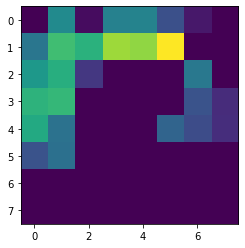

In [15]:
plt.imshow(norm_score_cam)

In [21]:
bac_score_cam = ScoreCam(normpneum_test_model, bac_img_array, normpneum_final_layer)

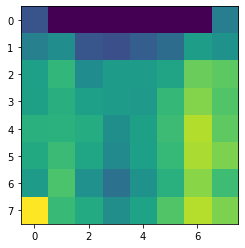

In [17]:
vir_score_cam = ScoreCam(normpneum_test_model, vir_img_array, normpneum_final_layer)

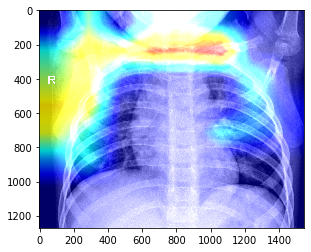

In [20]:
norm_superimposed = superimpose(norm_img_filename, norm_score_cam)
bac_superimposed = superimpose(bac_img_filename, bac_score_cam)
vir_superimposed = superimpose(vir_img_filename, vir_score_cam)

f, axarr = plt.subplots(3, 2)
axarr[0, 0].imshow(norm_score_cam)
axarr[0, 0].set_title('Normal')
axarr[0, 1].imshow(bac_score_cam)
axarr[0, 1].set_title('Bacterial')
axarr[0, 2].imshow(vir_score_cam)
axarr[0, 2].set_title('Bacterial')


axarr[1, 0].imshow(norm_superimposed)
axarr[1, 0].set_title('Normal')
axarr[1, 1].imshow(bac_superimposed)
axarr[1, 1].set_title('Bacterial')
axarr[1, 2].imshow(vir_superimposed)
axarr[1, 2].set_title('Bacterial')